In [1]:
%matplotlib inline

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import (Input, Conv2D, MaxPooling2D,UpSampling2D, 
                          Conv2DTranspose, concatenate)
from keras.optimizers import Adam, SGD
import imageio
import tifffile as tiff
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard


/home/sumit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [4]:
import sys

In [5]:
sys.path.append('/media/sumit/DATA/uChicago/Capstone/SpaceNet_Roads_Sample/apls-master/src')

In [6]:
import apls_tools as ap

In [7]:
def simple_unet_model(n_classes=1, im_sz=1300, n_channels=3, n_filters_start=3, growth_factor=2):
    # Creating network model using functional API:
    
    # first
    n_filters = n_filters_start
    
    inputs = Input((im_sz, im_sz, n_channels))
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # second
    n_filters *= growth_factor  # increase number of filters when going down the U-Net
    
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    #conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    n_filters //= growth_factor  # decrease number of filters when going up the U-Net
    upconv = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv2)
    concat = concatenate([conv1,upconv], axis=-1)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(concat)
    #conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    
    # output
    output = Conv2D(n_channels, (1, 1), activation='sigmoid', padding='same')(conv3)
    model = Model(inputs=inputs, outputs=output)
    optimizer = Adam()
    # Compiling model with ADAM optimizer and logloss (aka binary crossentropy) as loss function
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
    return model

In [8]:
model = simple_unet_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1300, 1300, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1300, 1300, 3 84          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 650, 650, 3)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 650, 650, 6)  168         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_tra

In [9]:
import imageio
import matplotlib as mpl
from matplotlib import pyplot as plt 
from keras.utils import plot_model
mpl.rcParams['figure.figsize'] = (15,15)  # plot sizes

#plot_model(model, to_file='simple_unet.png', show_shapes=True)
#plt.imshow(imageio.imread('simple_unet.png'))

In [10]:
from keras.preprocessing import image

In [11]:
import os

directory = "/media/sumit/DATA/uChicago/Capstone/code/inputs"
input_files = []
mask_files = []

for filename in os.listdir(directory):
    if filename.endswith(".tif"):
        input_tif_file = os.path.join(directory, filename)
        #geojson_file = os.path.join(directory, "spacenetroads"+filename[3:-4]+".geojson")
        mask_tif_file = os.path.join(directory[:-6], "masks", filename[:-4]+".tif")
        input_files.append(input_tif_file)
        mask_files.append(mask_tif_file)

In [12]:
input_clean_array = np.array([image.img_to_array(image.load_img(name)) for name in input_files])

In [13]:
output_mask_array = np.array([image.img_to_array(image.load_img(name)) for name in mask_files])

In [14]:
input_clean_array.shape

(40, 1300, 1300, 3)

In [15]:
output_mask_array.shape

(40, 1300, 1300, 3)

In [16]:
input_clean_array = input_clean_array.astype('float32')/255
output_mask_array = output_mask_array.astype('float32')/255

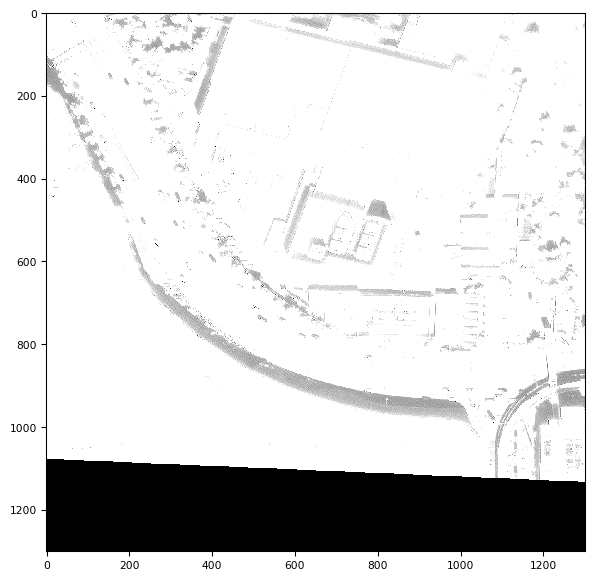

In [17]:
_ = tiff.imshow(input_clean_array[0])

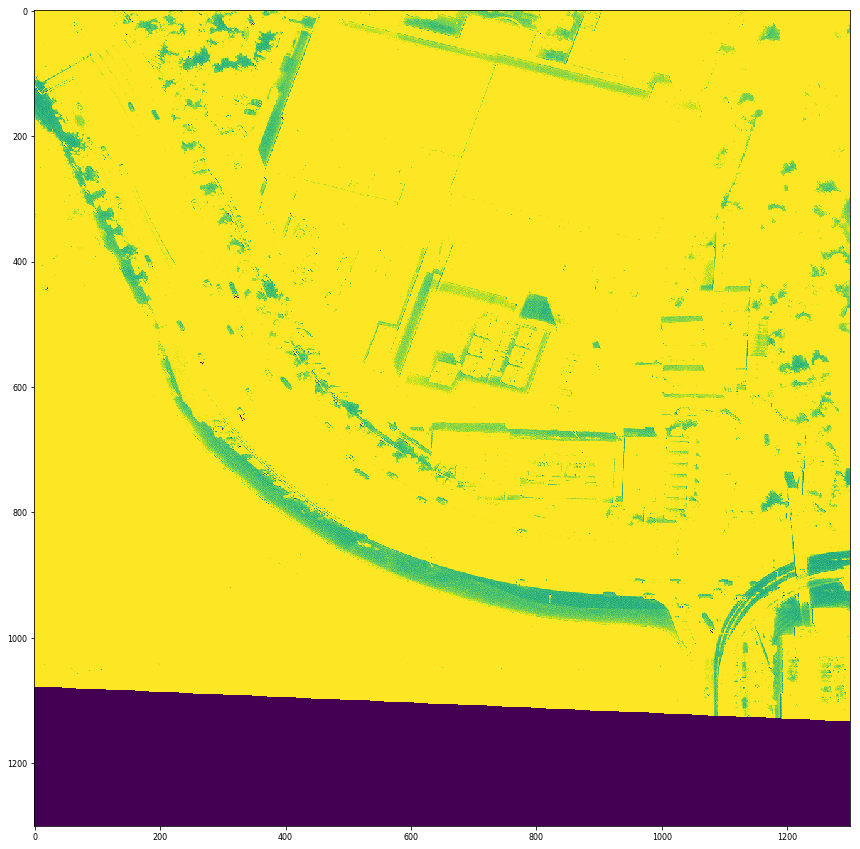

In [18]:
_ = plt.imshow(input_clean_array[0][:,:,0])

In [19]:
# Now training the model:
N_EPOCHS = 500
BATCH_SIZE = 3

# Fit:
model.fit(x=input_clean_array, y=output_mask_array, epochs=N_EPOCHS,verbose=0, shuffle=True)

ResourceExhaustedError: OOM when allocating tensor with shape[32,6,650,650] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_transpose_1/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_transpose_1/stack, conv2d_transpose_1/kernel/read, conv2d_2/Relu)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_155 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_837_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_transpose_1/conv2d_transpose', defined at:
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-5defac63bd4e>", line 1, in <module>
    model = simple_unet_model()
  File "<ipython-input-7-327970f76bdd>", line 18, in simple_unet_model
    upconv = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv2)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/convolutional.py", line 781, in call
    data_format=self.data_format)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3394, in conv2d_transpose
    data_format=tf_data_format)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1257, in conv2d_transpose
    name=name)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 805, in conv2d_backprop_input
    dilations=dilations, name=name)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/home/sumit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,6,650,650] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_transpose_1/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_transpose_1/stack, conv2d_transpose_1/kernel/read, conv2d_2/Relu)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_155 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_837_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [22]:
# Now training the model:
N_EPOCHS = 1000
BATCH_SIZE = 1

# Fit:
model1.fit(x=x3, y=mask3, epochs=N_EPOCHS,verbose=0, shuffle=True, validation_data=[x4, mask4])

In [20]:
pred3 = model1.predict(x3)
pred_img3 = pred3[0][:,:,0]
plt.imshow(pred_img3, cmap = 'gray')

NameError: name 'model1' is not defined

In [25]:
gdf1

,geometry,bridge_typ,heading,lane_numbe,lane_number,one_way_ty,paved,road_id,road_type,origarea,origlen,partialDec,truncated,type,highway
class,,,,,,,,,,,,,,,
highway,(POLYGON ((-115.2829359601807 36.1693810929461...,2,0,2,2,2,2,12886,6,0,0.002275,1,0,6,highway


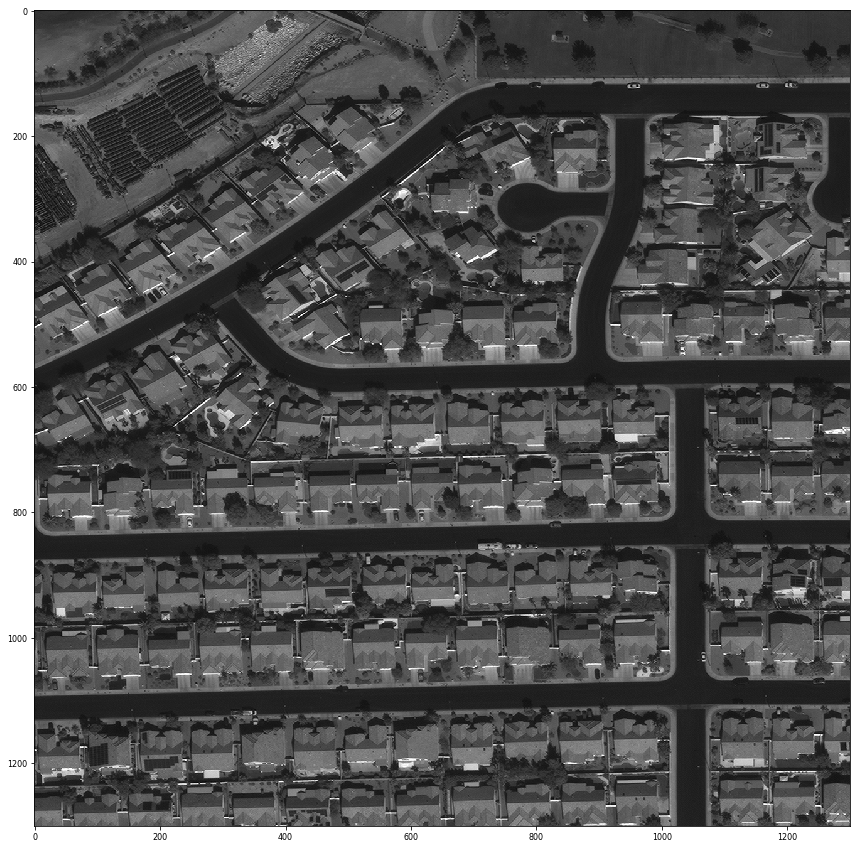

In [26]:
plt.imshow(tiff.imread(img3), cmap = 'gray')

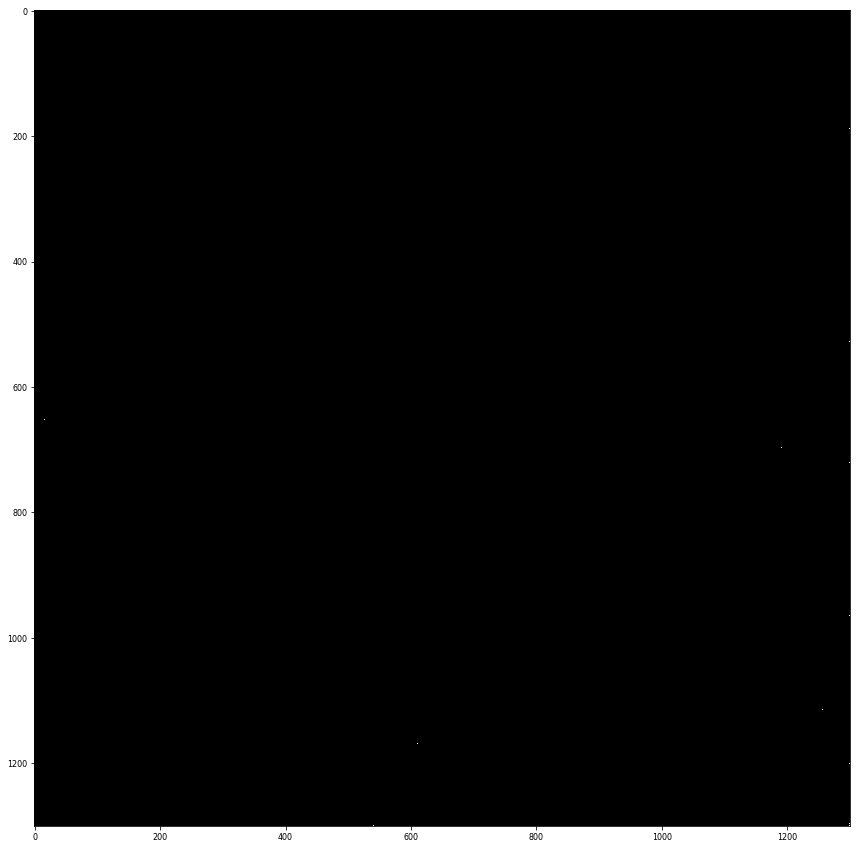

In [27]:
pred4 = model1.predict(x4)
pred_img4 = pred4[0][:,:,0]
plt.imshow(pred_img4, cmap='gray')

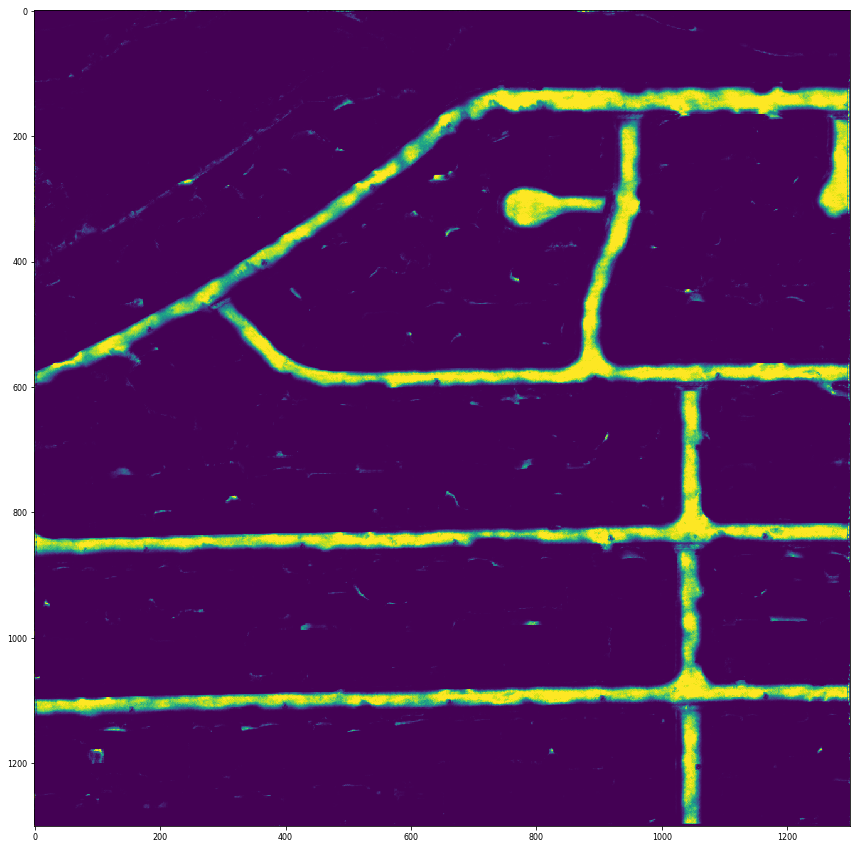

In [34]:
pred1 = model.predict(x1)
pred_img1 = pred1[0][:,:,0]
plt.imshow(pred_img1)

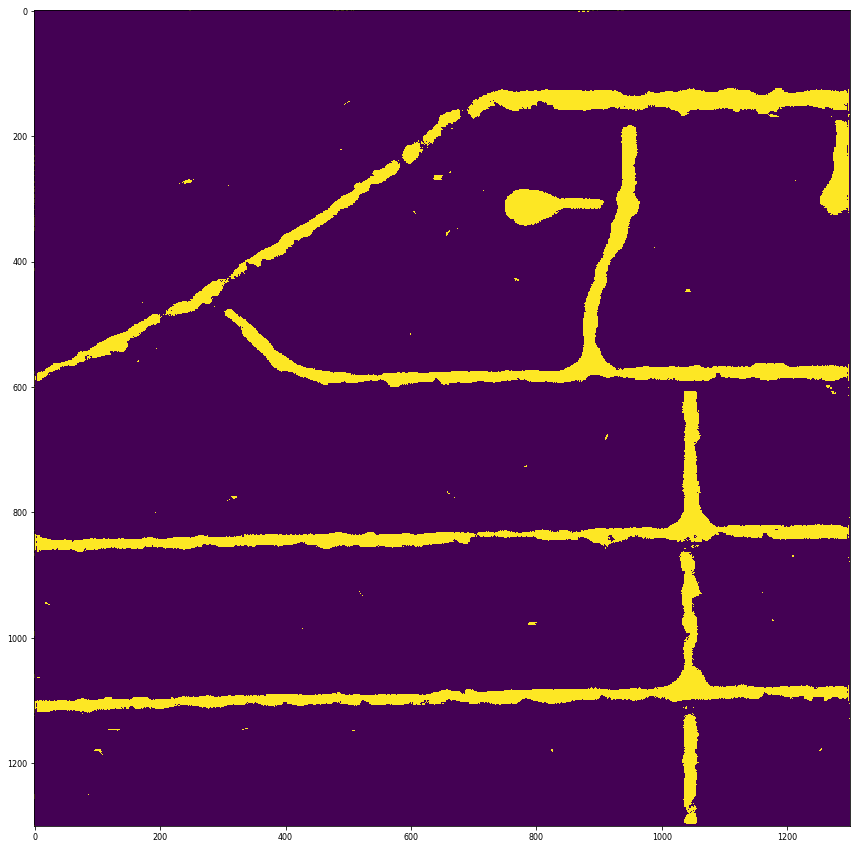

In [35]:
pred_img1[pred_img1>0.4]=1
pred_img1[pred_img1<=0.4]=0
plt.imshow(pred_img1)

In [21]:
# predict using second image
pred = model.predict(x2)
pred_img = pred[0][:,:,0]
plt.imshow(pred_img)

NameError: name 'x2' is not defined

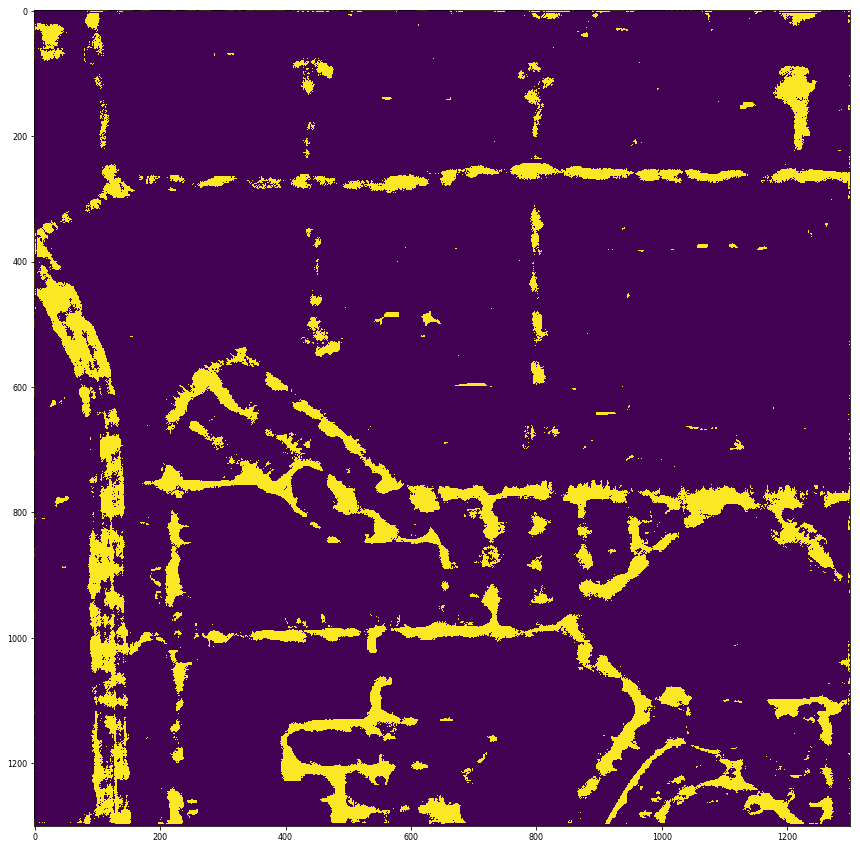

In [37]:
pred_img[pred_img >0.1]=1
pred_img[pred_img<=0.1]=0
plt.imshow(pred_img)

In [130]:
inputs = Input((None, None, 3))
conv = Conv2D(filters=3, kernel_size=(7, 7), strides=(1,1), 
              padding='same', use_bias=False)(inputs)
conv_model = Model(inputs=inputs, outputs=conv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x14b38e1d0>)

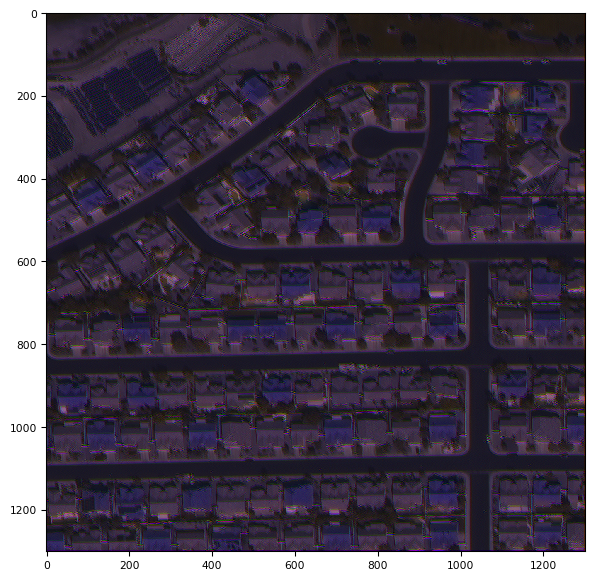

In [132]:
x1_conv = conv_model.predict(x1)
tiff.imshow(x1_conv[0])

In [98]:
inputs = Input((None, None, 3))
upconv = Conv2DTranspose(filters=3, kernel_size=(21, 21), strides=(2,2),
                         padding='same', use_bias=False)(inputs)
upconv_model = Model(inputs=inputs, outputs=upconv)
upconv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, None, None, 3)     3969      
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [99]:
x1_upconv = upconv_model.predict(x1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x142862208>)

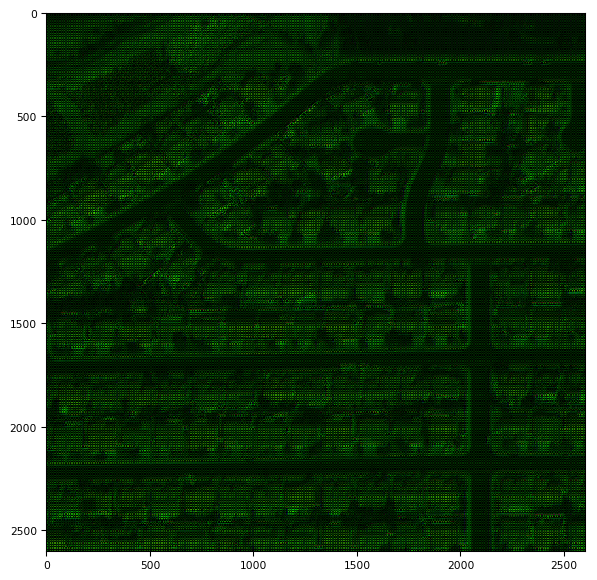

In [102]:
tiff.imshow(x1_upconv[0])